#  Real Estate Valuation

This is a real estate multivariate regression problem. Well be going through the "checklist" defined in Appendix B in the book [Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291). I'll be expliclity answering all the questions and going through each step to improve my learning, even though a lot of the questions don't make sense or apply super well to just doing this process for learning.

I'll preface answers with

> Pretend

if I'm making up an answer for this example.

In [1]:
# allows our matplotlib graphs to be display inline
%matplotlib inline

In [39]:
import urllib.request # for fetching our raw data from the web
import pandas as pd # for easily manipulating our data
from pandas.plotting import scatter_matrix # for comparing all columns against each other
import seaborn as sns # for pretty graphs
from scipy.stats import shapiro # for testing for normality
import statsmodels.api as sm # for making QQ plots

## Part A: Frame the Problem and Look at the Big Picture
 
1. Define the objective in business terms.

(Pretend) We want to predict real estate valuations in New Taipei City, Taiwan to increase our ability to effectively bid on lots.

2. How will your solution be used?

(Pretend) Our solution will be used to ensure we our bids are accurate, maximizing profit.

3. What are the current solutions/workarounds (if any)?

None.

4. How should you frame this problem (supervised/unsupervised, online/offline, etc.)?

Supervised. The data sets have house_price_of_unit_area attached. 

Offline. All the data that existed has been already gathered and all the training will be done at once.

5. How should performance be measured?

When deciding which performance metric to use, we have a lot of options to pick from.

1. Mean Squared Error (MSE)
2. Root Mean Squared Error (RMSE)
3. Mean Absolute Error (MAE)
4. R Squared (R²)
5. Adjusted R Squared $(R²)$
6. Mean Square Percentage Error (MSPE)
7. Mean Absolute Percentage Error (MAPE)
8. Root Mean Squared Logarithmic Error (RMSLE)

I have decided that we'll use MAE:

$\text{MAE} = \frac{1}{N}\sum_{i=1}^{N}|{y_{i}-\hat{y}_{i}}|$

I've decided to use MAE, as I believe we'll have some outliers in our data set. 

I used this [article](https://towardsdatascience.com/how-to-select-the-right-evaluation-metric-for-machine-learning-models-part-1-regrression-metrics-3606e25beae0) to help decide what would be a proper performance measurement.

6. Is the performance measure aligned with the business objective?

Yes, since we're predicting the value of houses, we'll be able to look at our error function's output and compare different models against each other, knowing we can treat a 10 MSE as exactly twice as bad as a 5 MSE. This works very well with the financial aspect of what we're modeling here.

7. What would be the minimum performance needed to reach the business objective?

(Pretend) We want to be within 25% of the valuation of a house, so we can see if it is worth gathering more data to try and further refine our model.

8. What are comparable problems? Can you reuse experience or tools?

(Pretend) Our company has had no comparable problems, nor can we reuse experience or tools.

9. Is human expertise available?

(Pretend) No.

10. How would you solve the problem manually?

I'd attempt to solve this problem manually by looking at all the houses that sold for the most amount and the houses that sold for the least amount and look for patterns that may elude to what would effect each house's price.

11. List the assumptions you (or others) have made so far.

While I have no assumptions regarding the dataset as a whole, I'll be listing column specific assumptions in section C.

12. Verify assumptions if possible.

Will do in Part C.

## Part B: Get the Data

_Note: automate as much as possible so you can easily get fresh data._

1. List the data you need and how much you need.

We'll just use the dataset we found before starting this project. If we were to answer this without acknowledging the dataset we've already found, we'd want a many rows as possible where columns would be potential variables that contributed to valuation of a house.

2. Find and document where you can get that data.

We can get this data at this [location])(https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set).

3. Check how much space it will take.

32 KB.

4. Check legal obligations, and get authorization if necessary.

UCI's data is free.

5. Get access authorizations.

Not needed.

6. Create a workspace (with enough storage space).

Done using [Cookiecutter Data Science](https://drivendata.github.io/cookiecutter-data-science/).

7. Get the data.

Done below.

8. Convert the data to a format you can easily manipulate (without changing the data itself).

Not needed.

9. Ensure sensitive information is deleted or protected (e.g., anonymized).

Not needed.

10. Check the size and type of data (time series, sample, geographical, etc.).

I'm not sure what to call the kind of data we're working with. Each row represents the action of selling a house, how much it sold for and a few other potentially related measurements.

11. Sample a test set, put it aside, and never look at it (no data snooping!).

We'll do this later, as we have cleaning to perform in the next section.

In [3]:
# We we should store our raw hosuing data
STORE_RAW_HOUSING_DATA_DESTINATION_PATH = "../data/raw/real_estate_valuation_data_set.xlsx"

In [4]:
def fetch_raw_housing_data(STORE_RAW_HOUSING_DATA_DESTINATION_PATH: str = STORE_RAW_HOUSING_DATA_DESTINATION_PATH):
    """Fetches our raw housing data.
    
    """
    # We we can fetch out raw data from
    RAW_DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00477/Real%20estate%20valuation%20data%20set.xlsx"
    
    urllib.request.urlretrieve(RAW_DATA_URL, STORE_RAW_HOUSING_DATA_DESTINATION_PATH)
    
fetch_raw_housing_data()

In [5]:
def load_raw_hosuing_data(STORE_RAW_HOUSING_DATA_DESTINATION_PATH: str = STORE_RAW_HOUSING_DATA_DESTINATION_PATH) -> pd.DataFrame:
    """Loads the raw housing data we've previously fetched
    
    """
    
    # creating our base data frame
    df = pd.read_excel(STORE_RAW_HOUSING_DATA_DESTINATION_PATH, index_col = "No")
    
    # renaming columns to drop the not needed X or Y prefix
    df.columns = ["transaction_date", "house_age", "distance_to_the_nearest_MRT_station", "number_of_convenience_stores", "latitude", "longitude", "house_price_of_unit_area"]
    
    return df

df = load_raw_hosuing_data()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 1 to 414
Data columns (total 7 columns):
transaction_date                       414 non-null float64
house_age                              414 non-null float64
distance_to_the_nearest_MRT_station    414 non-null float64
number_of_convenience_stores           414 non-null int64
latitude                               414 non-null float64
longitude                              414 non-null float64
house_price_of_unit_area               414 non-null float64
dtypes: float64(6), int64(1)
memory usage: 25.9 KB


In [7]:
df.describe()

,transaction_date,house_age,distance_to_the_nearest_MRT_station,number_of_convenience_stores,latitude,longitude,house_price_of_unit_area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148953,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281995,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.666667,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.916667,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.166667,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.416667,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583333,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


In [8]:
df.head()

,transaction_date,house_age,distance_to_the_nearest_MRT_station,number_of_convenience_stores,latitude,longitude,house_price_of_unit_area
No,,,,,,,
1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


We have successfully gathered the data we need.

## Part C: Explore the Data

_Note: try to get insights from a field expert for these steps._

1. Create a copy of the data for exploration (sampling it down to a manageable size if necessary).

The data is not big enough for me to consider this necessary. 

2. Create a Jupyter notebook to keep a record of your data exploration.

We'll be doing that in this notebook.

3. Study each attribute and its characteristics:

  - Name
  - Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
  - % of missing values
  - Noisiness and type of noise (stochastic, outliers, rounding errors, etc.)
  - Possibly useful for the task?
  - Type of distribution (Gaussian, uniform, logarithmic, etc.)
  
Will do on a column by column basis. Skipping noiseness analysis.

4. For supervised learning tasks, identify the target attribute(s).

The taret attribute is `house_price_of_unit_area`

5. Visualize the data.

We'll do this column by column and then a big scatter matrix.

6. Study the correlations between attributes.

We'll evaluate the correlations visually and by using Pearson's R.

7. Study how you would solve the problem manually.

8. Identify the promising transformations you may want to apply.

9. Identify extra data that would be useful (go back to “Get the Data”).

10. Document what you have learned.

We'll address each column, starting with the information the [website](https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set) we got the data from and then moving into any observations we have ourselves regarding the data. Then we'll use the `describe` function to get a general feel for the data, along with a hsitogram and followed by performing the Shapiro-Wilk test to test for normality. This test was chosen as we have a small number of samples, which is generally a perferred prerequisite for this test. 

### Column `transaction_date`

> the transaction date (for example, 2013.250=2013 March, 2013.500=2013 June, etc.)

In [29]:
def high_level_overview(column: pd.Series, alpha: int = 0.05):
    """Gives a high level overview of a single Pandas column.
    
    """
    print(column.describe())
    print(sns.violinplot(column))
    
    # visual normality test
    sm.qqplot(column, line='45')
    
    # mathmatical normality test
    stat, p = shapiro(column)
    print(f"\nShapiro-Wilk stat {stat} p {p}")
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

count     414.000000
mean     2013.148953
std         0.281995
min      2012.666667
25%      2012.916667
50%      2013.166667
75%      2013.416667
max      2013.583333
Name: transaction_date, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)

Shapiro-Wilk stat 0.934929370880127 p 1.8203687255496925e-12
Sample does not look Gaussian (reject H0)


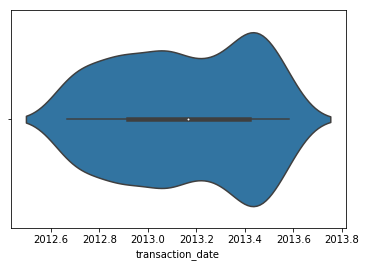

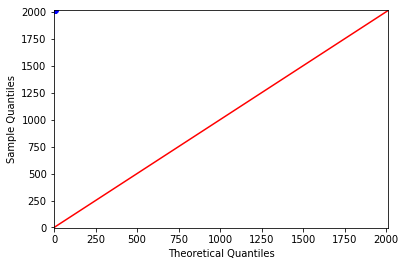

In [30]:
high_level_overview(df["transaction_date"])

- Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
  - date
- % of missing values
  - 0%
- Possibly useful for the task?
  - Yes, I believe that we will see a trend of houses getting more expensive we as get into later dates as generally real estate gets more valuable with time, along with inflation increasing the value
- Type of distribution (Gaussian, uniform, logarithmic, etc.)
  - TODO
- Assumptions
  - house_price_of_unit_area and transaction date will have a positive correlation
- Normalness
  - The column not being Gaussian does not really matter, as this is just dates. Why would sales of a house take place around a specific point of time and slowly ramp up and die down? 

### Column `house_age`

> the house age (unit: year)

count    414.000000
mean      17.712560
std       11.392485
min        0.000000
25%        9.025000
50%       16.100000
75%       28.150000
max       43.800000
Name: house_age, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)

Shapiro-Wilk stat 0.9467390179634094 p 4.79820315424373e-11
Sample does not look Gaussian (reject H0)


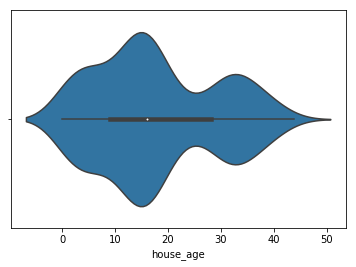

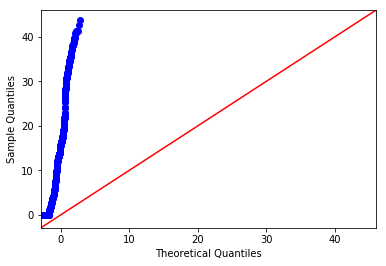

In [31]:
high_level_overview(df["house_age"])

- Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
  - float
- % of missing values
  - 0%
- Possibly useful for the task?
  - Yes, I believe that we will see a trend of prices relating to housing age. I'm not sure if newer houses will be more expensive, due to being built more recently, but potentially older houses may be worth more due to being bigger or landmark sites, potentially as an otulier.
- Type of distribution (Gaussian, uniform, logarithmic, etc.)
  - TODO
- Assumption
  - house_price_of_unit_area and house age will have a negative correlation
- Normalness
  - The column not being Gaussian does not really matter, as this is the age of the house. Why would most houses be made around a specific time, slowly build up and taper off?

### Column `distance_to_the_nearest_MRT_station`

> the distance to the nearest MRT station (unit: meter)

Where MRT = metro rail transit.

count     414.000000
mean     1083.885689
std      1262.109595
min        23.382840
25%       289.324800
50%       492.231300
75%      1454.279000
max      6488.021000
Name: distance_to_the_nearest_MRT_station, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)

Shapiro-Wilk stat 0.7381015419960022 p 4.8551144525880555e-25
Sample does not look Gaussian (reject H0)


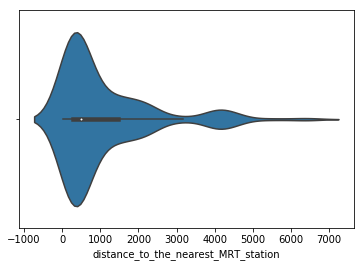

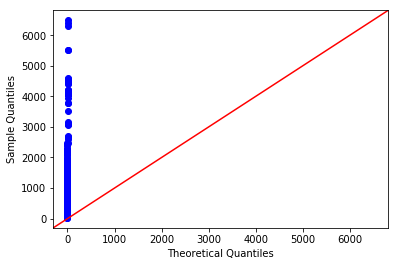

In [32]:
high_level_overview(df["distance_to_the_nearest_MRT_station"])

- Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
  - float
- % of missing values
  - 0%
- Possibly useful for the task?
  - Yes, I believe the distance to a MRT station wil be a good indicator for how urban or rural a house is.
- Type of distribution (Gaussian, uniform, logarithmic, etc.)
  - TODO
- Assumpions
  - house_price_of_unit_area and distance to the nearest MRT station will have a negative correlation
- Normalness
  - TODO

### Column `number_of_convenience_stores `

> the number of convenience stores in the living circle on foot (integer)

count    414.000000
mean       4.094203
std        2.945562
min        0.000000
25%        1.000000
50%        4.000000
75%        6.000000
max       10.000000
Name: number_of_convenience_stores, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)

Shapiro-Wilk stat 0.937370240688324 p 3.458723541946429e-12
Sample does not look Gaussian (reject H0)


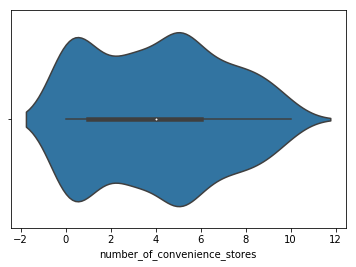

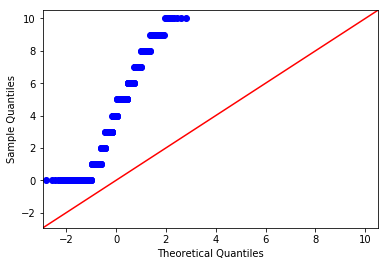

In [33]:
high_level_overview(df["number_of_convenience_stores"])

- Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
  - int
- % of missing values
  - 0%
- Possibly useful for the task?
  - Yes, I believe the number of convenience stores wil be a good indicator for how urban or rural a house is.
- Type of distribution (Gaussian, uniform, logarithmic, etc.)
  - TODO
- Assumpions
  - house_price_of_unit_area and number of convenience stores will have a positive correlation
- Normalness
  - TODO

### Column `latitude`

> the geographic coordinate, latitude. (unit: degree)

count    414.000000
mean      24.969030
std        0.012410
min       24.932070
25%       24.963000
50%       24.971100
75%       24.977455
max       25.014590
Name: latitude, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)

Shapiro-Wilk stat 0.9732920527458191 p 6.890189752084552e-07
Sample does not look Gaussian (reject H0)


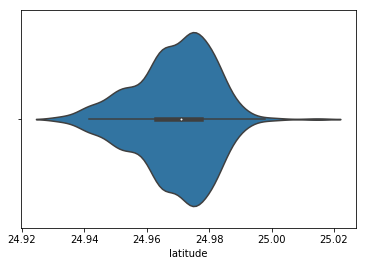

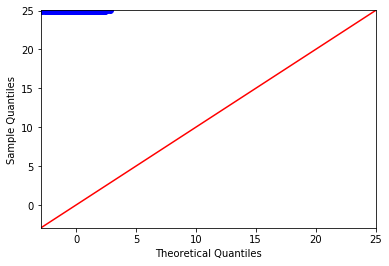

In [34]:
high_level_overview(df["latitude"])

- Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
  - float
- % of missing values
  - 0%
- Possibly useful for the task?
  - Yes, New Taipei City is a city bordered by water to the north, so I believe these coastal locations will be worth more
- Type of distribution (Gaussian, uniform, logarithmic, etc.)
  - TODO
- Assumptions
  - house_price_of_unit_area and latitude will have a positive correlation
- Normalness
  - TODO

### Column `longitude`

> the geographic coordinate, longitude. (unit: degree)

count    414.000000
mean     121.533361
std        0.015347
min      121.473530
25%      121.528085
50%      121.538630
75%      121.543305
max      121.566270
Name: longitude, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)

Shapiro-Wilk stat 0.8708114624023438 p 4.545777673730064e-18
Sample does not look Gaussian (reject H0)


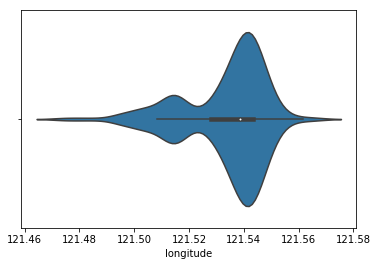

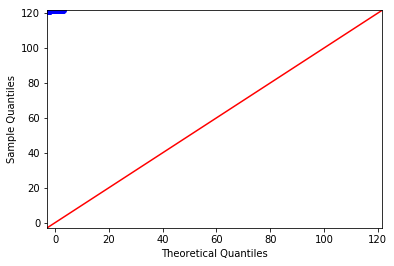

In [35]:
high_level_overview(df["longitude"])

- Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
  - float
- % of missing values
  - 0%
- Possibly useful for the task?
  - Yes, I believe longitude will help us identify how urban or rural a house is.
- Type of distribution (Gaussian, uniform, logarithmic, etc.)
  - TODO
- Assumptions
  - house_price_of_unit_area and longitdue will have a positive correlation
- Normalness
  - TODO

### Column `house_price_of_unit_area`

> house price of unit area (10000 New Taiwan Dollar/Ping, where Ping is a local unit, 1 Ping = 3.3 meter squared) 

count    414.000000
mean      37.980193
std       13.606488
min        7.600000
25%       27.700000
50%       38.450000
75%       46.600000
max      117.500000
Name: house_price_of_unit_area, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)

Shapiro-Wilk stat 0.972750186920166 p 5.412278483163391e-07
Sample does not look Gaussian (reject H0)


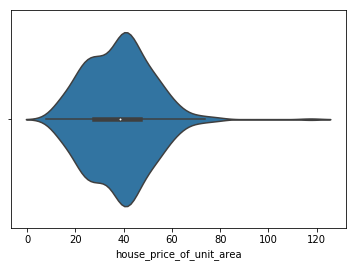

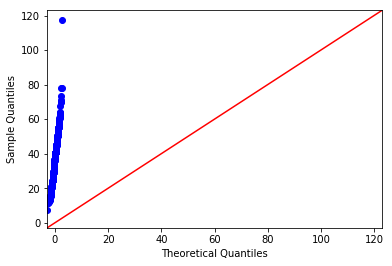

In [38]:
high_level_overview(df["house_price_of_unit_area"])

Class variable, also known as what we're trying to predict, not much analysis needed on this column, as all other columns have been evaluated against this one.

## All Columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13fdb8908>,
      dtype=object)

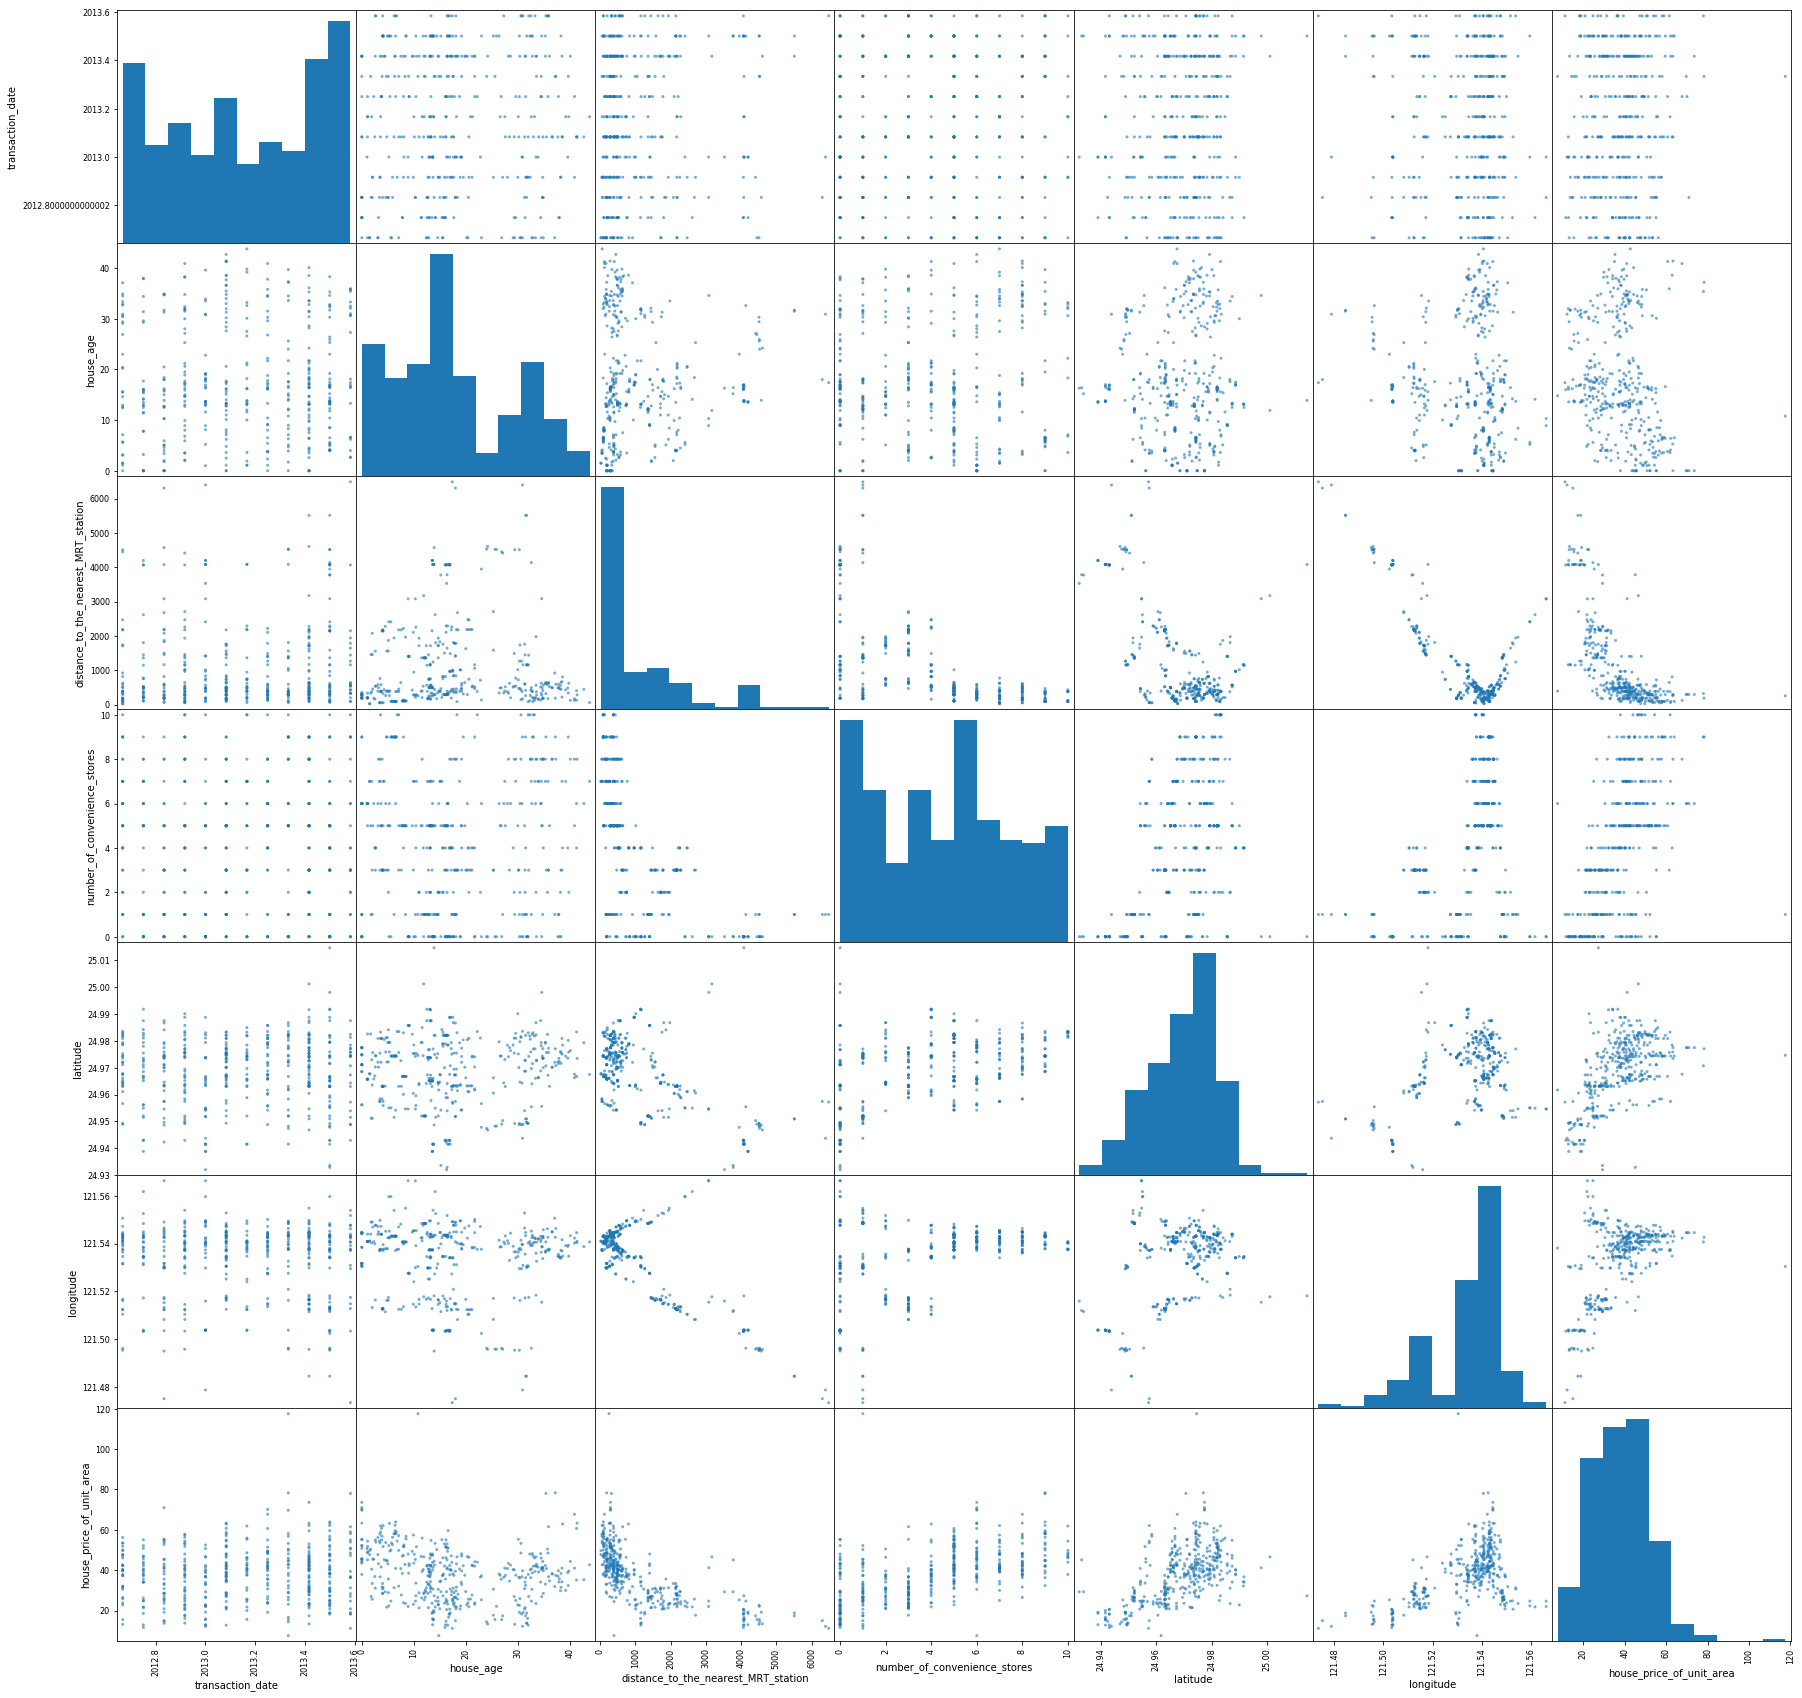

In [45]:
scatter_matrix(df, alpha=0.6, figsize=(30, 30), diagonal='hist')

I like to look at the scatter matrix when we don't have a lot of columns, just to look at the big picture in one big graph. This generally isn't the best way to check for correlation between two columns, as its a visual check. Instead we'll be using Pearson's R, also know as the standard correlation coefficient.

In [46]:
corr_matrix = df.corr()
corr_matrix["house_price_of_unit_area"].sort_values(ascending=False)

house_price_of_unit_area               1.000000
number_of_convenience_stores           0.571005
latitude                               0.546307
longitude                              0.523287
transaction_date                       0.087529
house_age                             -0.210567
distance_to_the_nearest_MRT_station   -0.673613
Name: house_price_of_unit_area, dtype: float64

The correlation coefficients range from $-1$ to $1$. Close to $1$ tells us there's a strong positive correlation, while close to $-1$ means there's a strong negative correlation, and close to $0$ means no correlation.

We see here that `number_of_convenience_stores`, `latitude` and `longitude` look to have a strong positive correlation, while I'd say `transaction-date` has no correlation.

`house_age` has a weak negative correlation and `distance_to_the_nearest_MRT_station` has a strong negative correlation. 

## Part D: Prepare the Data

Notes:
  - Work on copies of the data (keep the original dataset intact).
  - Write functions for all data transformations you apply, for five reasons:
    1. So you can easily prepare the data the next time you get a fresh dataset
    2. So you can apply these transformations in future projects
    3. To clean and prepare the test set
    4. To clean and prepare new data instances once your solution is live
    5. To make it easy to treat your preparation choices as hyperparameters
    
1. Data cleaning:
  - Fix or remove outliers (optional).
  - Fill in missing values (e.g., with zero, mean, median...) or drop their rows (or columns).
2. Feature selection(optional):
  - Drop the attributes that provide no useful information for the task.
3. Feature engineering, where appropriate:
  - Discretize continuous features.
  - Decompose features (e.g., categorical, date/time, etc.).
  - Add promising transformations of features (e.g., log(x), sqrt(x), x^2, etc.).
  - Aggregate features into promising new features.
4. Feature scaling: standardize or normalize features.

## Part E: Short-List Promising Models

Notes:
  - If the data is huge, you may want to sample smaller training sets so you can train many different models in a reasonable time (be aware that this penalizes complex models such as large neural nets or Random Forests).
  - Once again, try to automate these steps as much as possible.
  
1. Train many quick and dirty models from different categories (e.g., linear, naive Bayes, SVM, Random Forests, neural net, etc.) using standard parameters.
2. Measure and compare their performance. For each model, use N-fold cross-validation and compute the mean and standard deviation of the performance measure on the N folds.
3. Analyze the most significant variables for each algorithm.
4. Analyze the types of errors the models make. What data would a human have used to avoid these errors?
5. Have a quick round of feature selection and engineering.
6. Have one or two more quick iterations of the five previous steps.
7. Short-list the top three to five most promising models, preferring models that make different types of errors.

## Part F: Fine-Tune the System

Notes:
- You will want to use as much data as possible for this step, especially as you move toward the end of fine-tuning.
- As always automate what you can.

1. Fine-tune the hyperparameters using cross-validation.
  - Treat your data transformation choices as hyperparameters, especially when you are not sure about them (e.g., should I replace missing values with zero or with the median value? Or just drop the rows?). Unless there are very few hyperparameter values to explore, prefer random search over grid search. If training is very long, you may prefer a Bayesian optimization approach (e.g., using Gaussian process priors, as described by Jasper Snoek, Hugo Larochelle, and Ryan Adams).

2. Try Ensemble methods. Combining your best models will often perform better than running themindividually.
3. Once you are confident about your final model, measure its performance on the test set to estimate the generalization error.

WARNING: Don’t tweak your model after measuring the generalization error: you would just start overfitting the test set

## Part G: Present Your Solution

1. Document what you have done.
2. Create a nice presentation. 
  - Make sure you highlight the big picture first.
3. Explain why your solution achieves the business objective.
4. Don’t forget to present interesting points you noticed along the way. 
  - Describe what worked and what did not. 
  - List your assumptions and your system’s limitations.
5. Ensure your key findings are communicated through beautiful visualizations or easy-to-remember statements (e.g., “the median income is the number-one predictor of housing prices”).

## Part H: Launch!

1. Get your solution ready for production (plug into production data inputs, write unit tests, etc.).
2. Write monitoring code to check your system’s live performance at regular intervals and trigger alerts when it drops.
  - Beware of slow degradation too: models tend to “rot” as data evolves.
  - Measuring performance may require a human pipeline (e.g., via a crowdsourcing service).
  - Also monitor your inputs’ quality (e.g., a malfunctioning sensor sending random values, or another team’s output becoming stale). This is particularly important for online learning systems.
3. Retrain your models on a regular basis on fresh data (automate as much as possible).